In [1]:
#used Google Colab for this portion
!pip install transformers

In [2]:
import nltk
nltk.download('punkt')
from nltk import word_tokenize, sent_tokenize, tokenize
import pandas as pd
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
nltk.download('wordnet')
from sklearn.linear_model import LinearRegression
import datetime
import numpy as np

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
#create classifier pipeline using Jochen Hartmann's sentiment analysis model
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [4]:
df=pd.read_excel('/content/ClimateArticles.xlsx')

In [5]:
#total number of articles
len(df)

831

In [6]:
#create lists each of 7 emotions, one for the primary emotion, and one for the primary score
allprimary=[]
allprimaryscore=[]
allanger=[]
alldisgust=[]
allfear=[]
alljoy=[]
allneutral=[]
allsadness=[]
allsurprise=[]
for txt in df['Texts']:
    pred_txt=""
    sent=sent_tokenize(txt)
    for s in sent:
        if "climate change" in s.lower():
            pred_txt=pred_txt+" "+s
#if article is too long for model, split it in two, take the average, then normalize it
    try:
        prediction=classifier(pred_txt.lstrip(),)
    except:
        cli_text=sent_tokenize(pred_txt.lstrip())
        pred_txt=""
        for s1 in cli_text[:round(len(cli_text)/2)]:
            pred_txt=pred_txt+" "+s1
        prediction1=classifier(pred_txt.lstrip(),)
        pred_txt=""
        for s2 in cli_text[round(len(cli_text)/2):]:
            pred_txt=pred_txt+" "+s2
        prediction2=classifier(pred_txt.lstrip(),)
        pred_all=[(prediction1[0][0]['score']*prediction2[0][0]['score'])/2,
         (prediction1[0][1]['score']*prediction2[0][1]['score'])/2,
                  (prediction1[0][2]['score']*prediction2[0][2]['score'])/2,
                  (prediction1[0][3]['score']*prediction2[0][3]['score'])/2,
                  (prediction1[0][4]['score']*prediction2[0][4]['score'])/2,
                  (prediction1[0][5]['score']*prediction2[0][5]['score'])/2,
                  (prediction1[0][6]['score']*prediction2[0][6]['score'])/2]
        prediction=[[{'label': 'anger', 'score': pred_all[0]/sum(pred_all)},
  {'label': 'disgust', 'score': pred_all[1]/sum(pred_all)},
  {'label': 'fear', 'score': pred_all[2]/sum(pred_all)},
  {'label': 'joy', 'score': pred_all[3]/sum(pred_all)},
  {'label': 'neutral', 'score': pred_all[4]/sum(pred_all)},
  {'label': 'sadness', 'score': pred_all[5]/sum(pred_all)},
  {'label': 'surprise', 'score': pred_all[6]/sum(pred_all)}]]
    primary=0
    for i in range(1,7):
        if prediction[0][primary]['score']<prediction[0][i]['score']:
            primary=i
    #print(prediction[0][primary]['label'],prediction[0][primary]['score'])
    allprimary.append(prediction[0][primary]['label'])
    allprimaryscore.append(prediction[0][primary]['score'])
    allanger.append(prediction[0][0]['score'])
    alldisgust.append(prediction[0][1]['score'])
    allfear.append(prediction[0][2]['score'])
    alljoy.append(prediction[0][3]['score'])
    allneutral.append(prediction[0][4]['score'])
    allsadness.append(prediction[0][5]['score'])
    allsurprise.append(prediction[0][6]['score'])

Token indices sequence length is longer than the specified maximum sequence length for this model (574 > 512). Running this sequence through the model will result in indexing errors


In [7]:
#make columns out of the emotion lists
df['Primary Emotion']=allprimary
df['Primary Emotion Score']=allprimaryscore
df['Anger']=allanger
df['Disgust']=alldisgust
df['Fear']=allfear
df['Joy']=alljoy
df['Neutral']=allneutral
df['Sadness']=allsadness
df['Surprise']=allsurprise

In [8]:
#count number of times "climate change" appears in each article, add column
clinum=[]
for txt in df['Texts']:
    clinum.append(txt.lower().count("climate change"))

df['Count']=clinum

In [9]:
#format date in a way that makes sequential bargraphs by month easier to make
monthyear=[]
for d in df['Dates']:
    if d.month<10:
        monthyear.append(str(d.year)+'-0'+str(d.month))
    else:
        monthyear.append(str(d.year)+'-'+str(d.month))
df['Date']=monthyear

In [10]:
#identify whether articles are before or after landfall
hurrdates=[]
for date in df['Dates']:
    if date.year==2022 and date.month==9 and date.day<28:
        hurrdates.append("Before")
    elif date.year==2021:
        hurrdates.append("Before")
    elif date.year==2022 and date.month<9:
        hurrdates.append("Before")
    else:
        hurrdates.append("After")
df['Hurricane Ian']=hurrdates

In [11]:
#sort chronologically
df=df.sort_values(by=['Dates'])

In [12]:
#make column that identifies whether article is about local events using "Florida"
localnews=[]
for txt in df['Texts']:
    if 'florida' in txt.lower():
        localnews.append('Local')
    else:
        localnews.append('Other')
df['Local to Florida']=localnews

<Axes: xlabel='Dates', ylabel='Anger'>

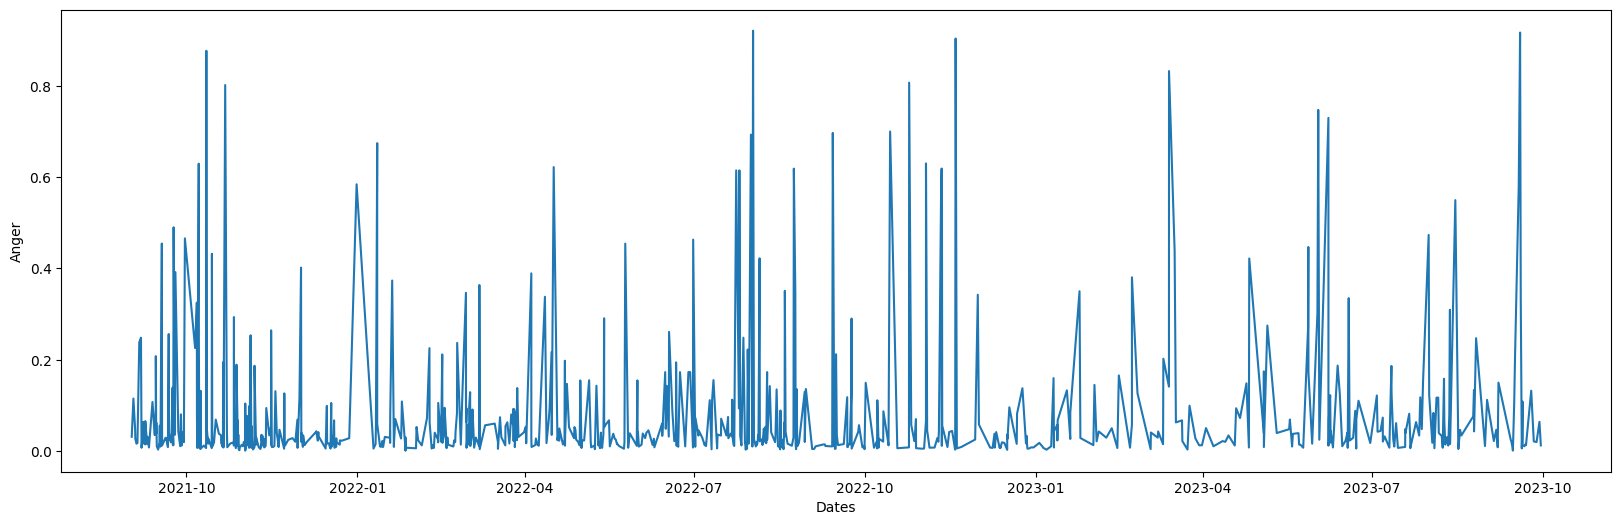

In [13]:
#line plot for anger. not useful.
plt.figure(figsize=(20,6))
sns.lineplot(data=df, x="Dates", y='Anger')

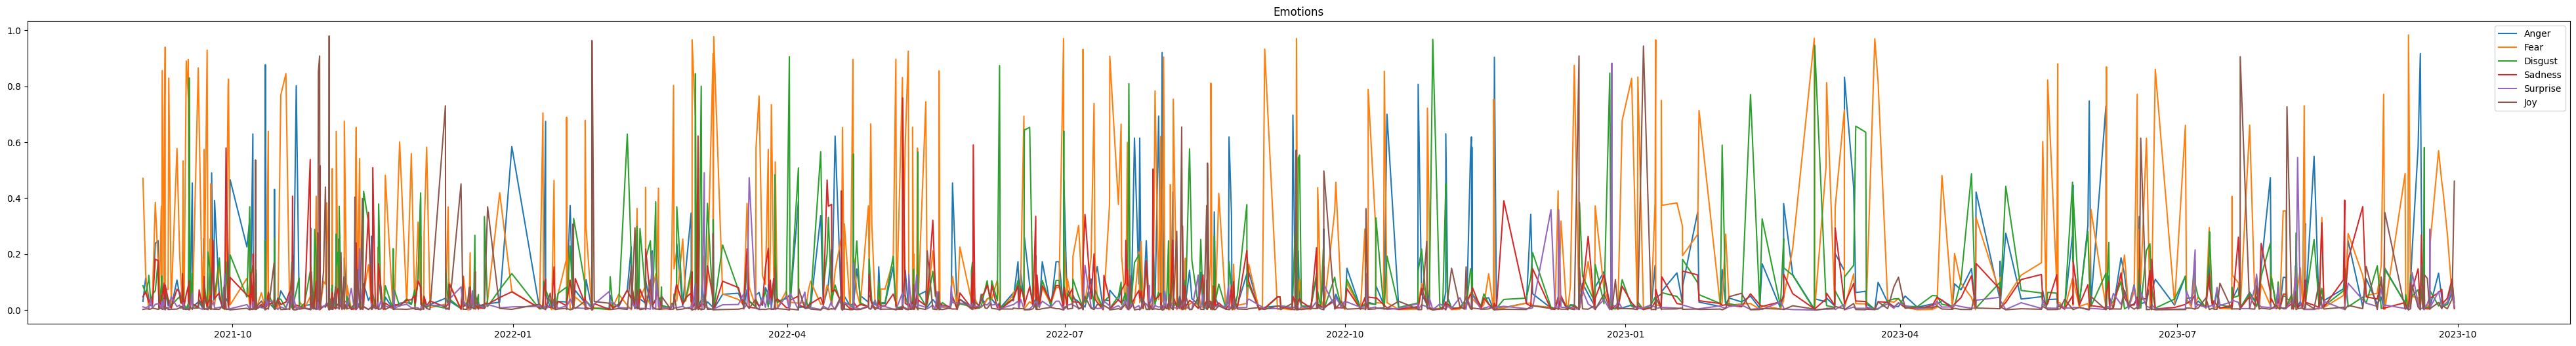

In [14]:
#line plot for all non-neutral emotions. not useful either.
fig, ax = plt.subplots(figsize=(50, 6))
ax.plot(df['Dates'], df['Anger'], label="Anger")
ax.plot(df['Dates'], df['Fear'], label="Fear")
ax.plot(df['Dates'], df['Disgust'], label="Disgust")
ax.plot(df['Dates'], df['Sadness'], label="Sadness")
ax.plot(df['Dates'], df['Surprise'], label="Surprise")
ax.plot(df['Dates'], df['Joy'], label="Joy")
#ax.plot(df['Dates'], df['Neutral'], label="Neutral")
plt.title('Emotions')
plt.legend()

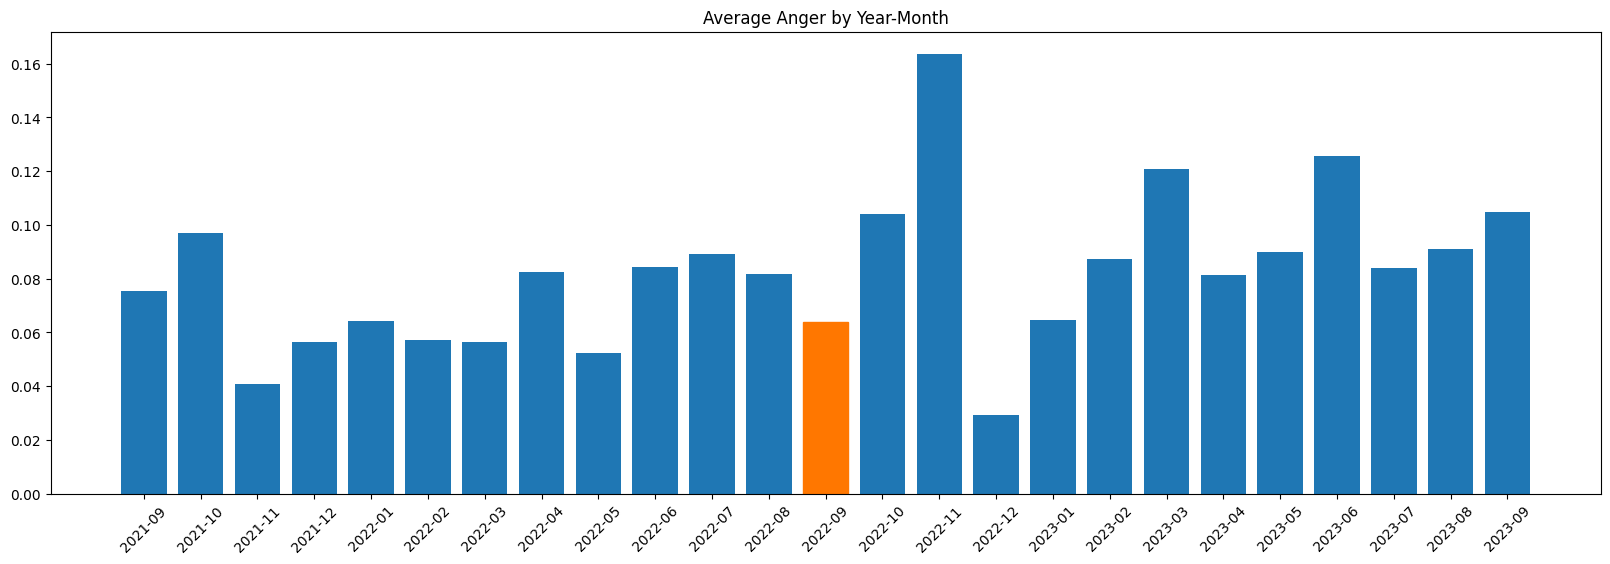

In [15]:
theseries=df.groupby('Date')['Anger'].mean().sort_index()
plt.figure(figsize=(20,6))
barlist=plt.bar(theseries.index, theseries.values)
barlist[12].set_color('#FF7700')
plt.xticks(rotation=45)
plt.title("Average Anger by Year-Month")
plt.show()

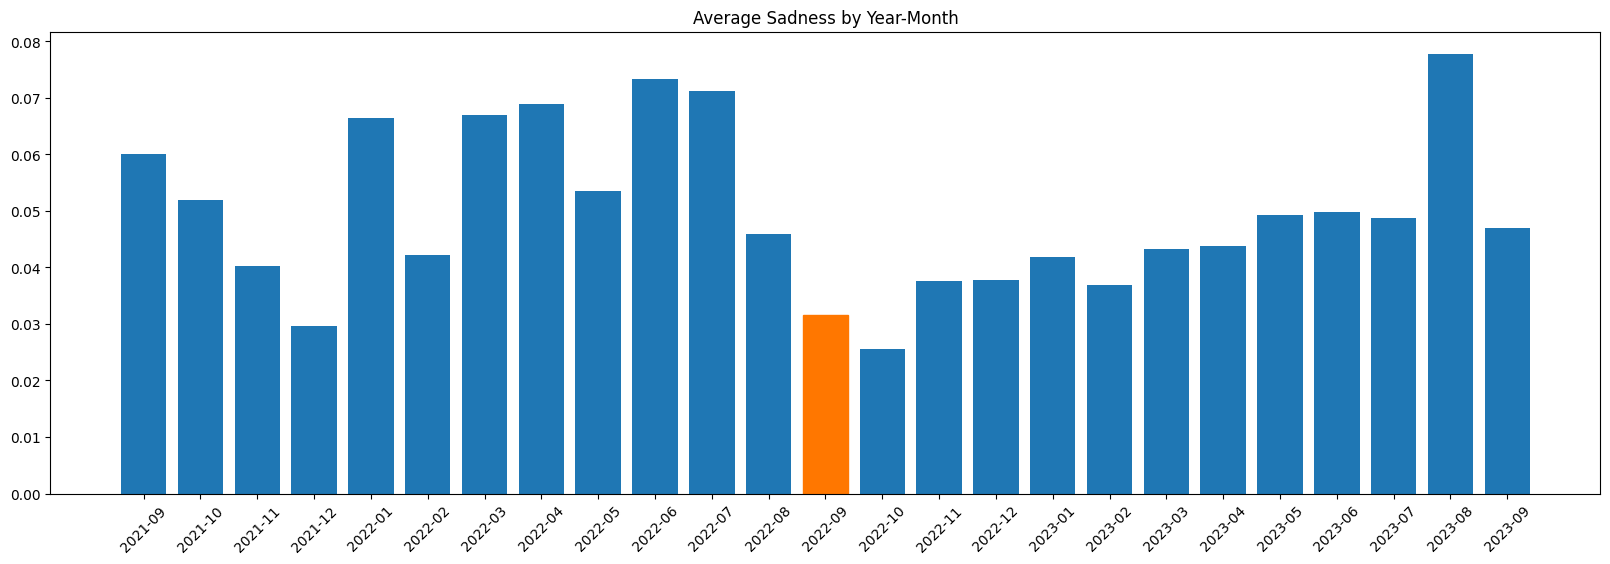

In [16]:
theseries=df.groupby('Date')['Sadness'].mean().sort_index()
plt.figure(figsize=(20,6))
barlist=plt.bar(theseries.index, theseries.values)
barlist[12].set_color('#FF7700')
plt.xticks(rotation=45)
plt.title("Average Sadness by Year-Month")
plt.show()

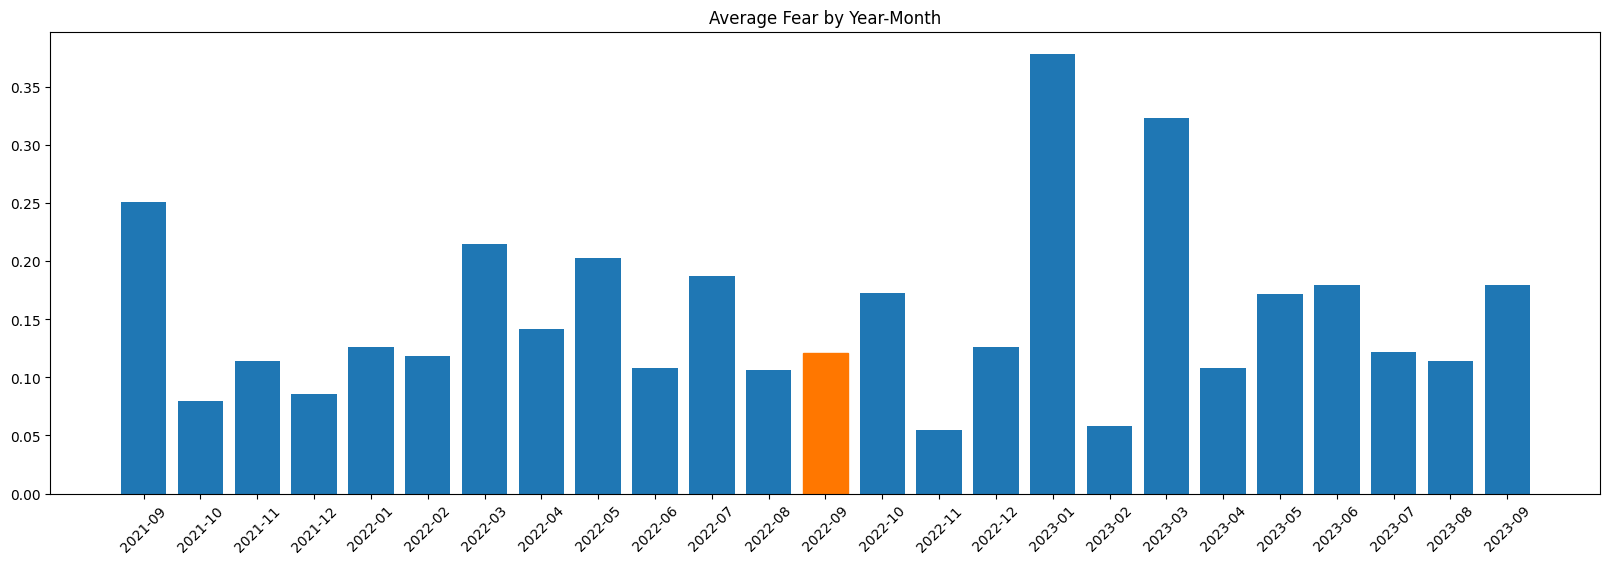

In [17]:
theseries=df.groupby('Date')['Fear'].mean().sort_index()
plt.figure(figsize=(20,6))
barlist=plt.bar(theseries.index, theseries.values)
barlist[12].set_color('#FF7700')
plt.xticks(rotation=45)
plt.title("Average Fear by Year-Month")
plt.show()

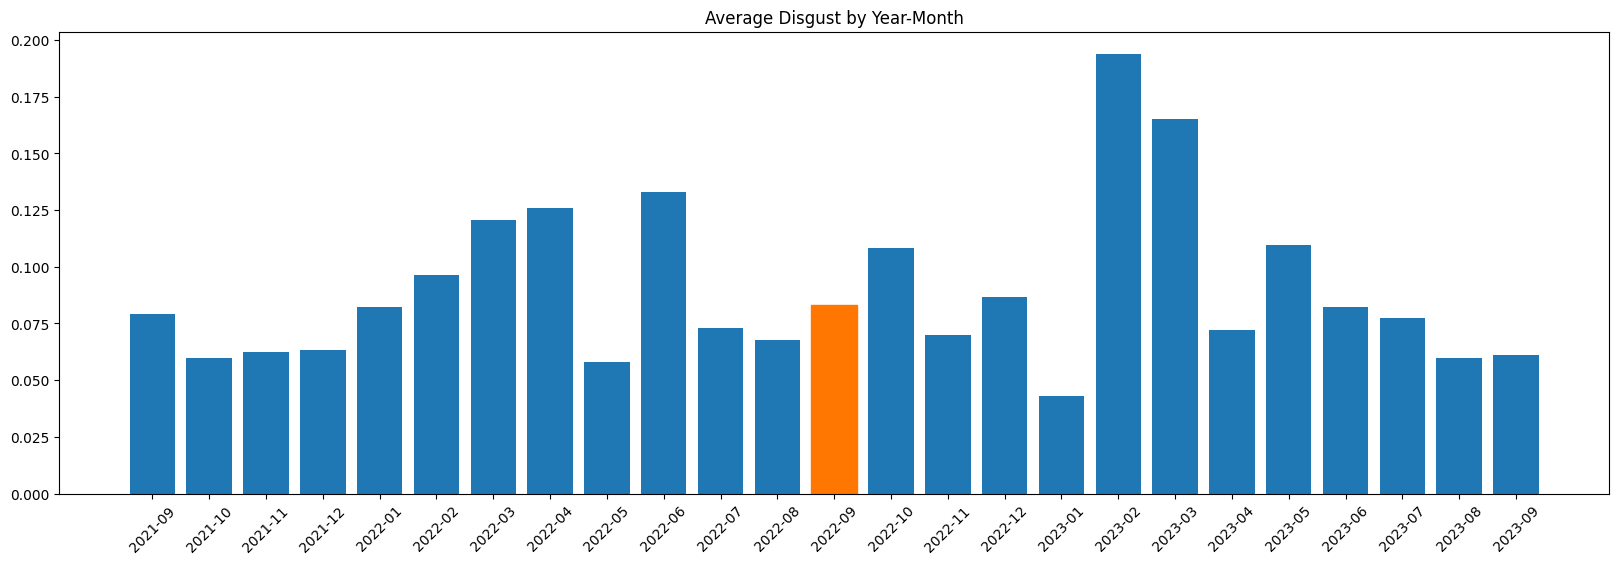

In [18]:
theseries=df.groupby('Date')['Disgust'].mean().sort_index()
plt.figure(figsize=(20,6))
barlist=plt.bar(theseries.index, theseries.values)
barlist[12].set_color('#FF7700')
plt.xticks(rotation=45)
plt.title("Average Disgust by Year-Month")
plt.show()

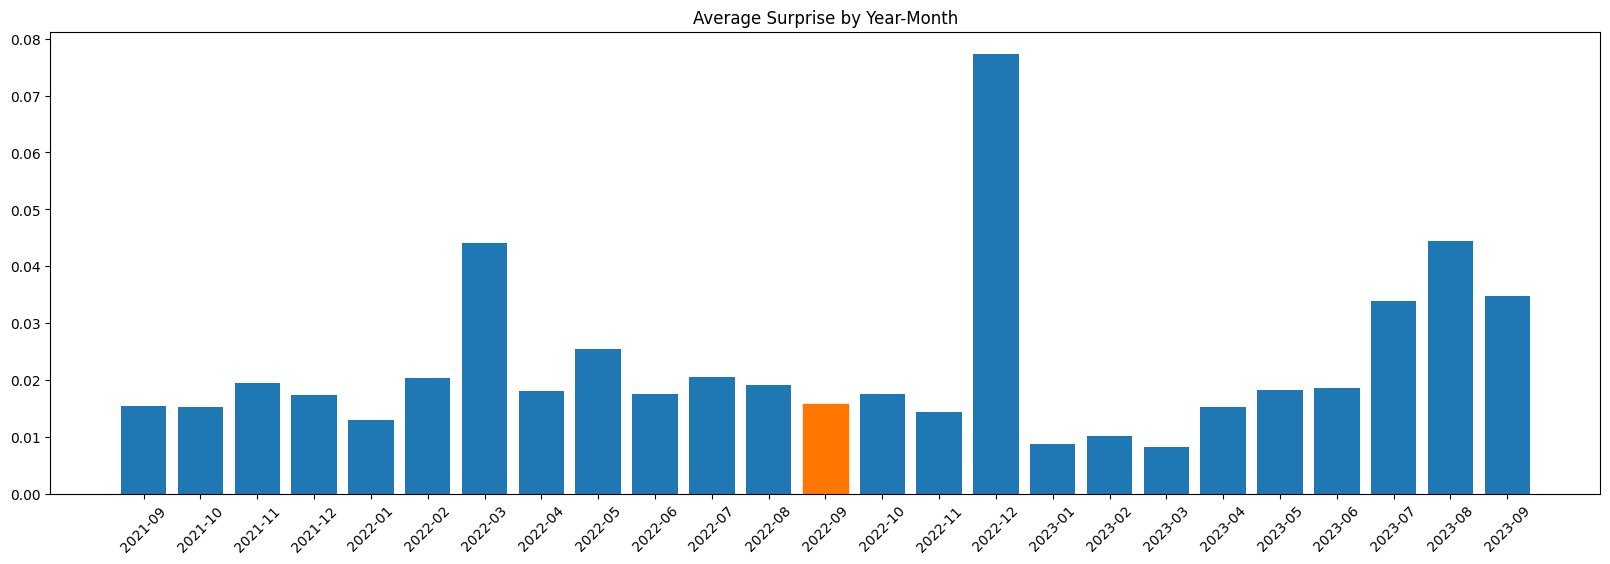

In [19]:
theseries=df.groupby('Date')['Surprise'].mean().sort_index()
plt.figure(figsize=(20,6))
barlist=plt.bar(theseries.index, theseries.values)
barlist[12].set_color('#FF7700')
plt.xticks(rotation=45)
plt.title("Average Surprise by Year-Month")
plt.show()

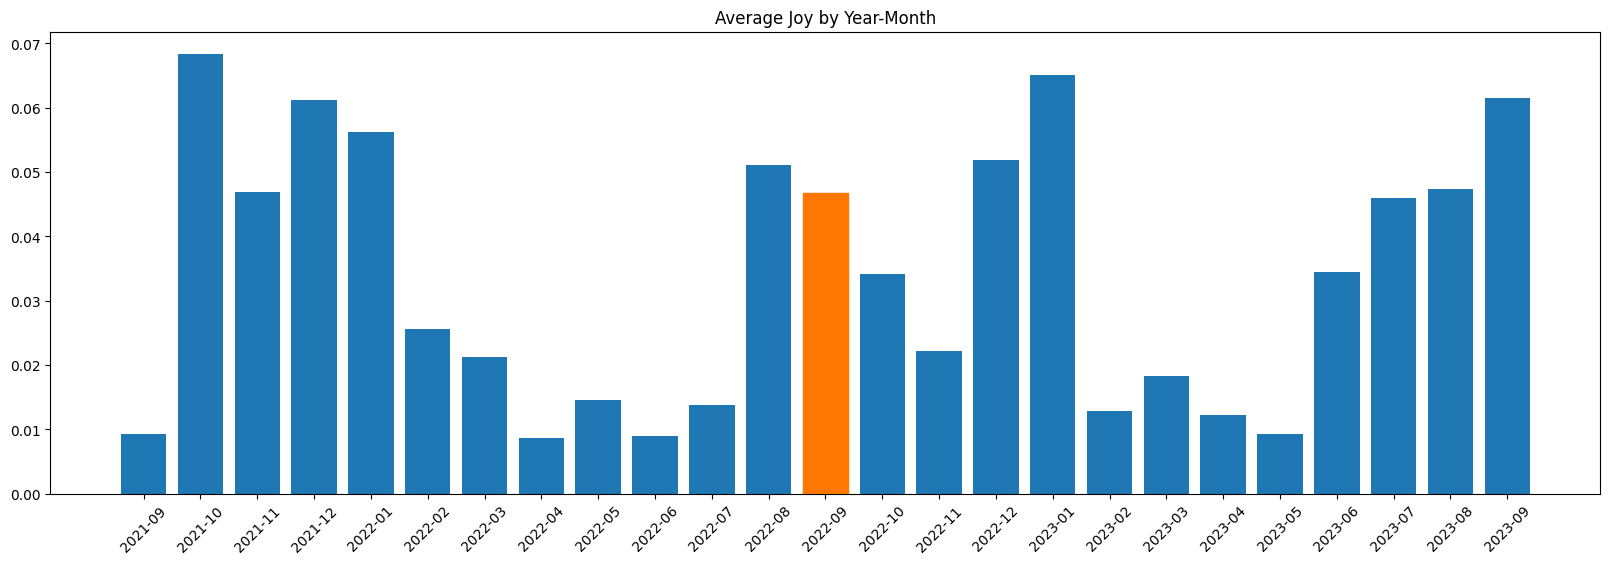

In [20]:
theseries=df.groupby('Date')['Joy'].mean().sort_index()
plt.figure(figsize=(20,6))
barlist=plt.bar(theseries.index, theseries.values)
barlist[12].set_color('#FF7700')
plt.xticks(rotation=45)
plt.title("Average Joy by Year-Month")
plt.show()

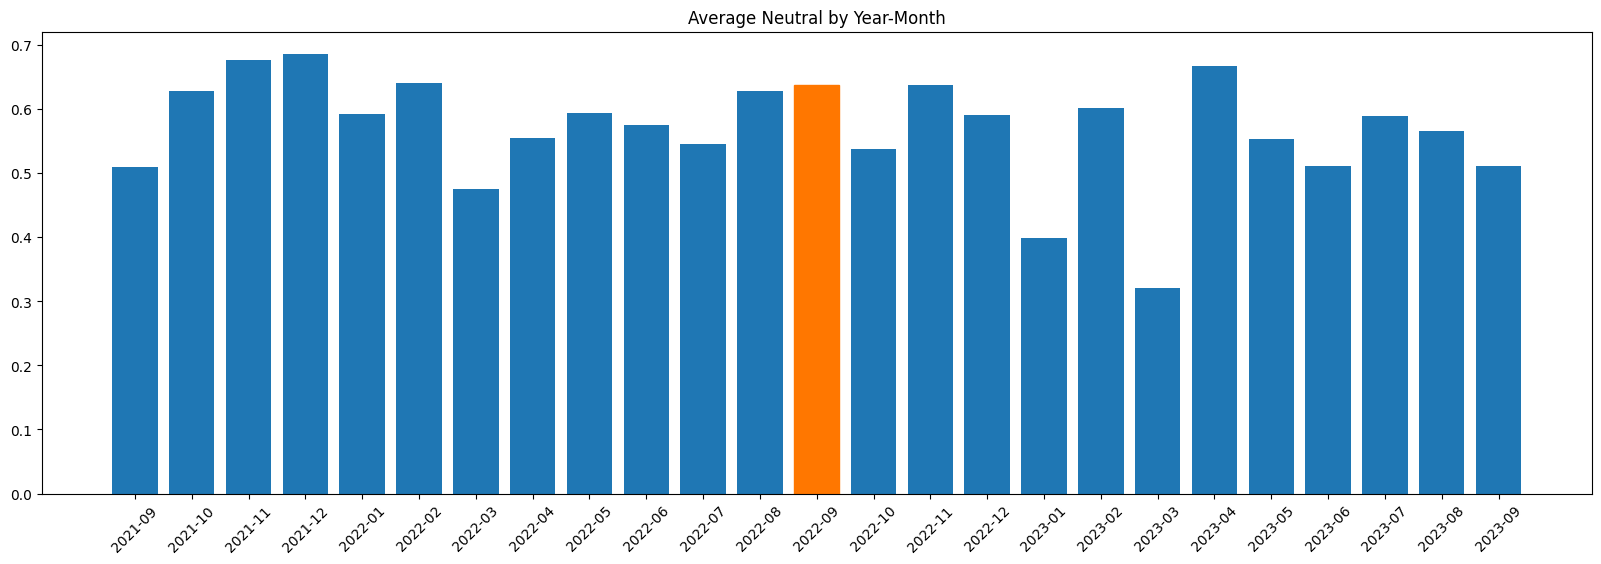

In [21]:
theseries=df.groupby('Date')['Neutral'].mean().sort_index()
plt.figure(figsize=(20,6))
barlist=plt.bar(theseries.index, theseries.values)
barlist[12].set_color('#FF7700')
plt.xticks(rotation=45)
plt.title("Average Neutral by Year-Month")
plt.show()

<ipython-input-22-f6b5d645c9ba>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  emonth=df.groupby('Date')['Anger','Fear','Disgust','Sadness','Surprise','Joy','Neutral'].mean().sort_index()


<Axes: title={'center': 'Emotion Heatmap by Month'}, ylabel='Date'>

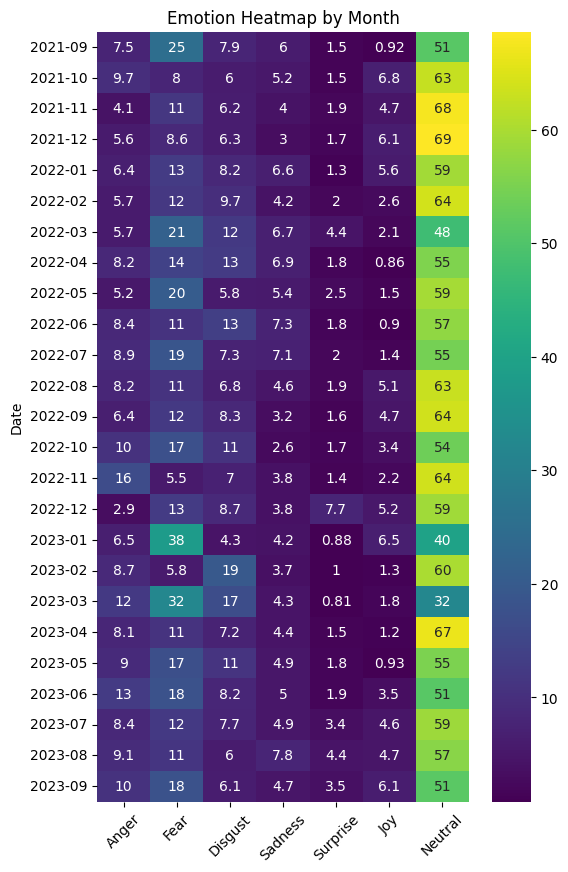

In [22]:
#all emotions heatmap by month
emonth=df.groupby('Date')['Anger','Fear','Disgust','Sadness','Surprise','Joy','Neutral'].mean().sort_index()
plt.figure(figsize=(6,10))
plt.xticks(rotation=45)
plt.title('Emotion Heatmap by Month')
sns.heatmap(emonth*100,annot=True,cmap='viridis')

<ipython-input-23-a8dc43562461>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  emonth=df.groupby('Date')['Anger','Fear','Disgust','Sadness','Surprise','Joy'].mean().sort_index()


<Axes: title={'center': 'Emotion Heatmap by Month'}, ylabel='Date'>

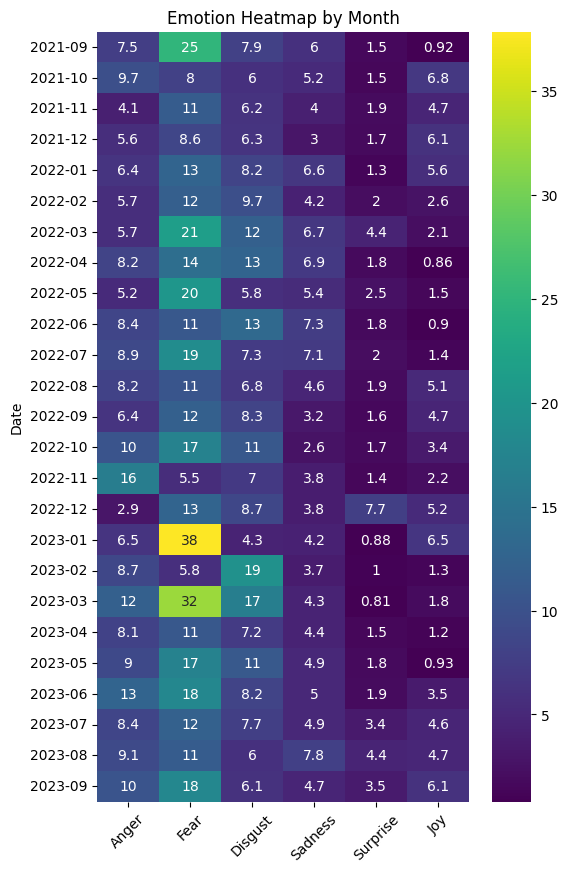

In [23]:
#non-neutral emotions heatmap by month
emonth=df.groupby('Date')['Anger','Fear','Disgust','Sadness','Surprise','Joy'].mean().sort_index()
plt.figure(figsize=(6,10))
plt.xticks(rotation=45)
plt.title('Emotion Heatmap by Month')
sns.heatmap(emonth*100,annot=True,cmap='viridis')

In [24]:
#group by landfall and non-neutral emotions
elandfall=df.groupby('Hurricane Ian')['Anger','Fear','Disgust','Sadness','Surprise','Joy'].mean().sort_index()

<ipython-input-24-09f99f2b5c58>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  elandfall=df.groupby('Hurricane Ian')['Anger','Fear','Disgust','Sadness','Surprise','Joy'].mean().sort_index()


In [25]:
#make "before" come first
elandfall=elandfall.reindex(["Before", "After"])

<Axes: title={'center': 'Emotion Heatmap by Landfall'}, ylabel='Hurricane Ian'>

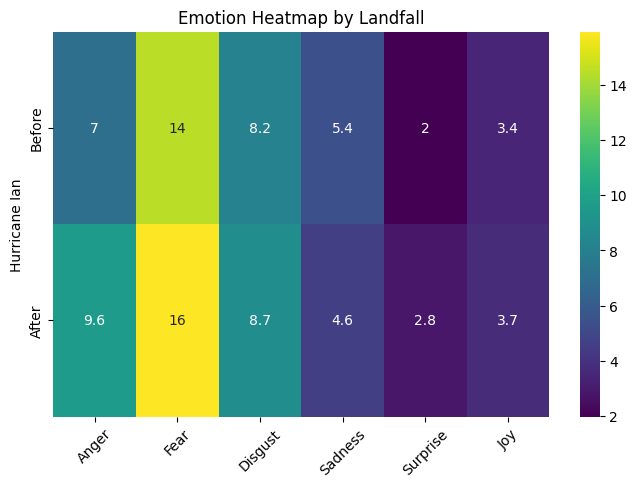

In [26]:
plt.figure(figsize=(8,5))
plt.xticks(rotation=45)
plt.title('Emotion Heatmap by Landfall')
sns.heatmap(elandfall*100,annot=True,cmap='viridis')

<ipython-input-27-e5243cf1bf7a>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  elandfall=df.groupby('Hurricane Ian')['Anger','Fear','Disgust','Sadness','Surprise','Joy','Neutral'].mean().sort_index()


<Axes: title={'center': 'Emotion Heatmap by Landfall'}, ylabel='Hurricane Ian'>

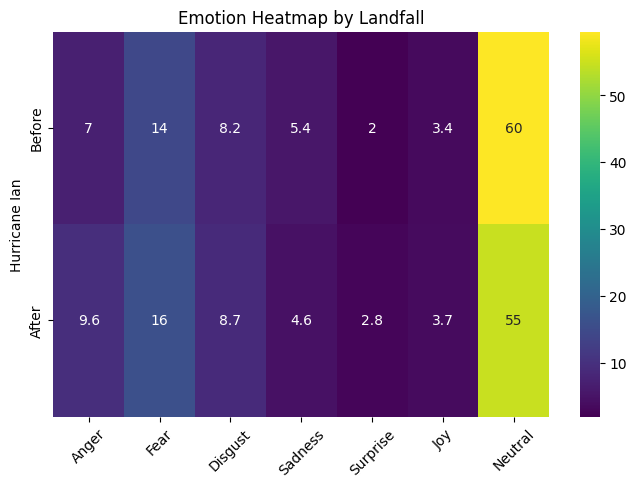

In [27]:
#group by landfall and all emotions
elandfall=df.groupby('Hurricane Ian')['Anger','Fear','Disgust','Sadness','Surprise','Joy','Neutral'].mean().sort_index()
elandfall=elandfall.reindex(["Before", "After"])
plt.figure(figsize=(8,5))
plt.xticks(rotation=45)
plt.title('Emotion Heatmap by Landfall')
sns.heatmap(elandfall*100,annot=True,cmap='viridis')

In [28]:
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')

In [29]:
#make one giant text from all cleaned/lemmatized climate change sentences from before landfall
cli_before=""
for txt in df.loc[df['Hurricane Ian']=='Before']['Texts']:
    sent=sent_tokenize(txt)
    for s in sent:
        if "climate change" in s.lower():
            for word in tokenize.wordpunct_tokenize(s):
                word=word.lower()
                if word not in stop_words and word not in string.punctuation and word.isalpha()==True:
                    cli_before=cli_before+" "+lemmatizer.lemmatize(word)
cli_before=cli_before.lstrip()
cli_before=cli_before.replace("said","").replace("climate","").replace("change","")

In [30]:
#make one giant text from all cleaned/lemmatized climate change sentences from after landfall
cli_after=""
for txt in df.loc[df['Hurricane Ian']=='After']['Texts']:
    sent=sent_tokenize(txt)
    for s in sent:
        if "climate change" in s.lower():
            for word in tokenize.wordpunct_tokenize(s):
                word=word.lower()
                if word not in stop_words and word not in string.punctuation and word.isalpha()==True:
                    cli_after=cli_after+" "+lemmatizer.lemmatize(word)
cli_after=cli_after.lstrip()
cli_after=cli_after.replace("said","").replace("climate","").replace("change","")

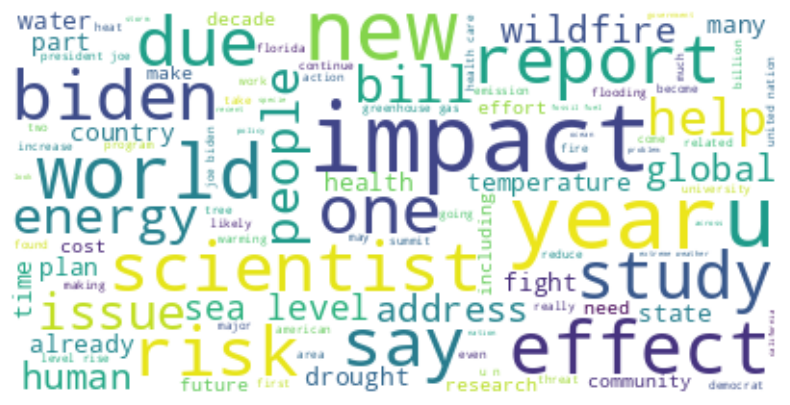

In [31]:
#word cloud before landfall
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(cli_before)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

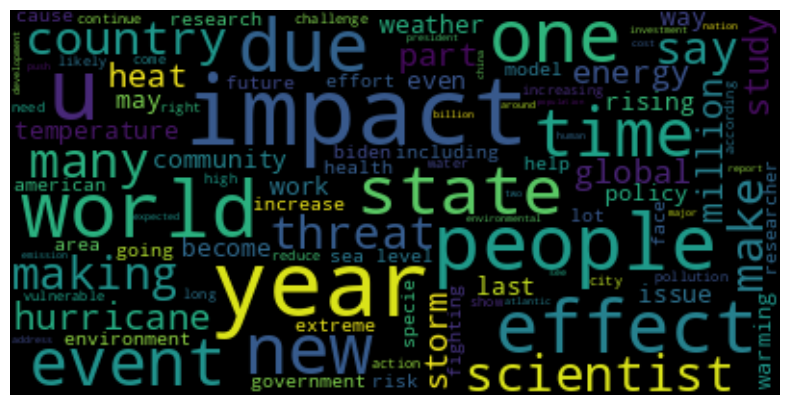

In [32]:
#word cloud after landfall
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(cli_after)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [33]:
#define urgency as a combination of anger, disgust, and fear
urgency=[]
for index, row in df.iterrows():
    urgency.append(row['Anger']+row['Disgust']+row['Fear'])

In [34]:
df['Urgency']=urgency

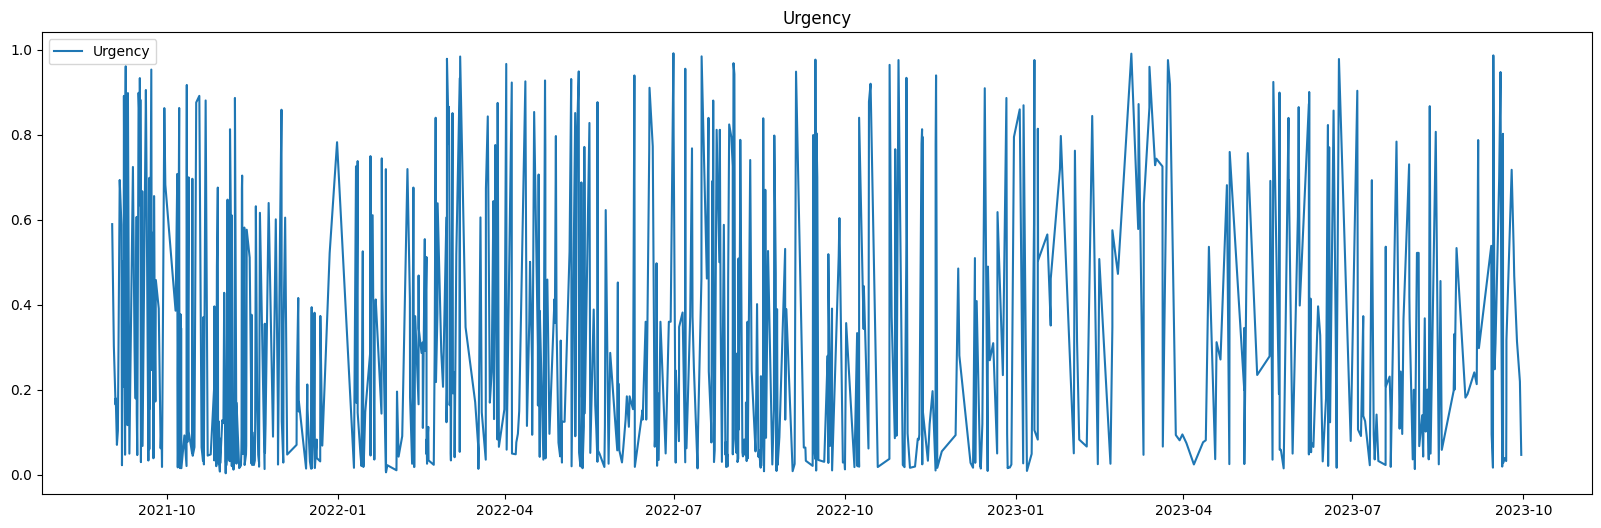

In [35]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(df['Dates'], df['Urgency'], label="Urgency")
plt.title('Urgency')
plt.legend()

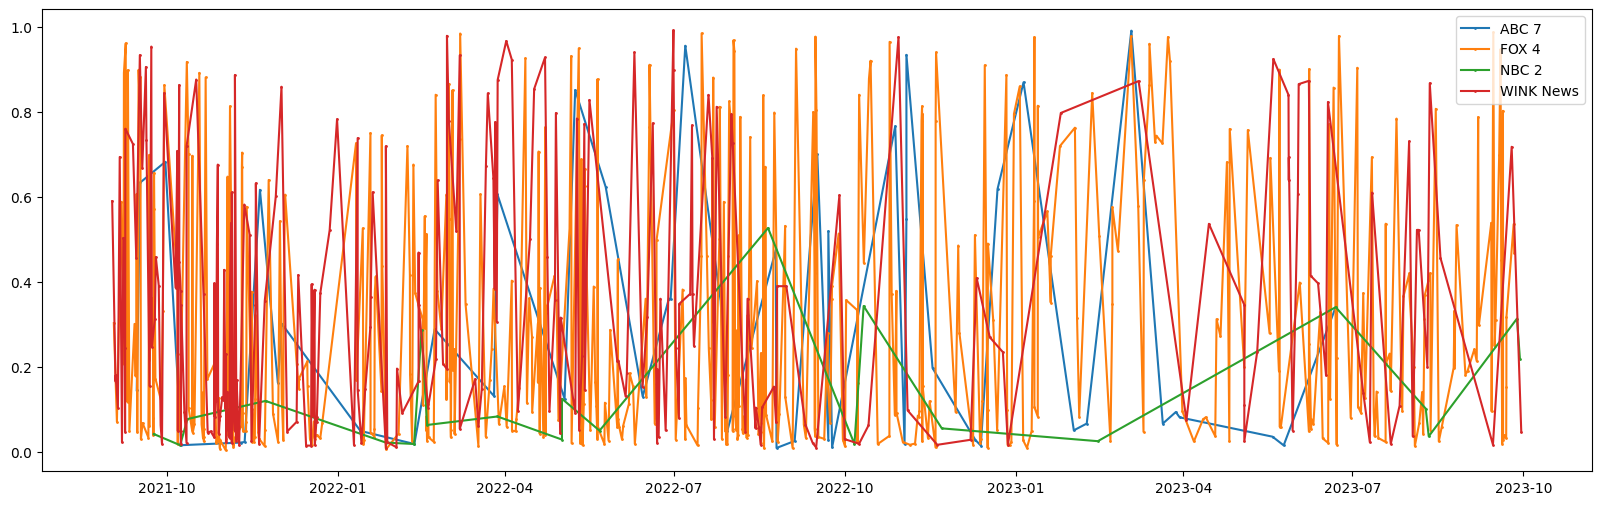

In [36]:
#graph urgency by source
groups = df.groupby('Source')
fig, ax = plt.subplots(figsize=(20, 6))
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.Dates, group.Urgency, marker='o', linestyle='-', ms=1, label=name)
ax.legend()

plt.show()

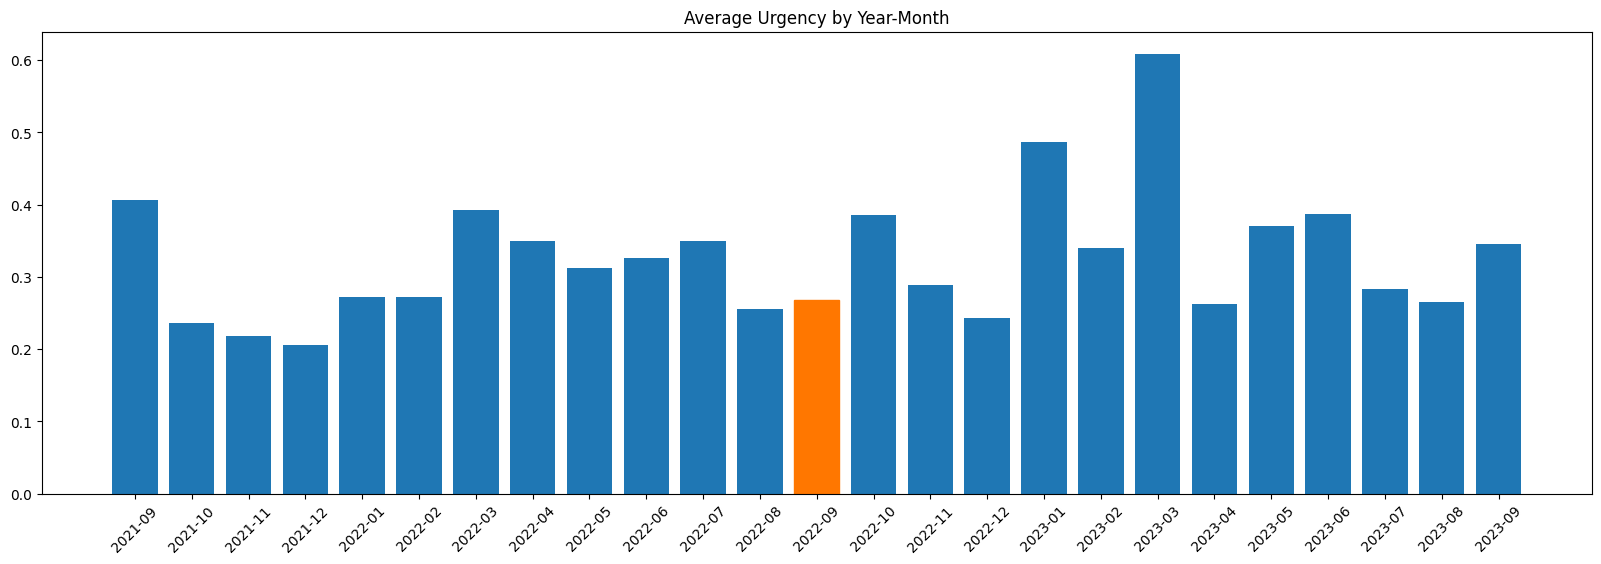

In [37]:
theseries=df.groupby('Date')['Urgency'].mean().sort_index()
plt.figure(figsize=(20,6))
barlist=plt.bar(theseries.index, theseries.values)
barlist[12].set_color('#FF7700')
plt.xticks(rotation=45)
plt.title("Average Urgency by Year-Month")
plt.show()

In [38]:
table = pd.pivot_table(df, values='Urgency', index=['Hurricane Ian'], columns=['Source'], aggfunc="mean")
table=table.reindex(["Before", "After"])

In [39]:
table

Source,ABC 7,FOX 4,NBC 2,WINK News
Hurricane Ian,,,,
Before,0.308897,0.273912,0.112206,0.347324
After,0.318432,0.344542,0.161479,0.379752


<Axes: title={'center': 'Urgency Heatmap by News Source'}, xlabel='Source', ylabel='Hurricane Ian'>

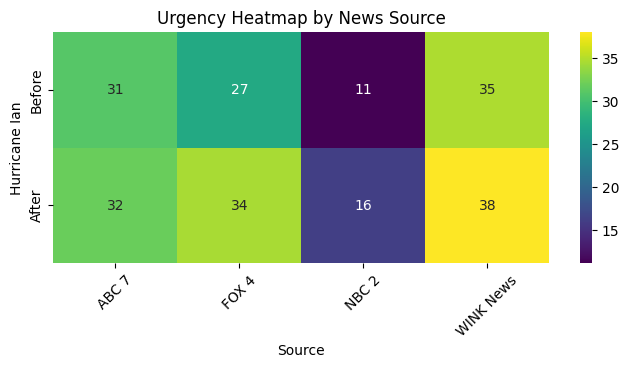

In [40]:
plt.figure(figsize=(8,3))
plt.xticks(rotation=45)
plt.title('Urgency Heatmap by News Source')
sns.heatmap(table*100,annot=True,cmap='viridis')

Text(0.5, 1.0, 'Urgency by News Source')

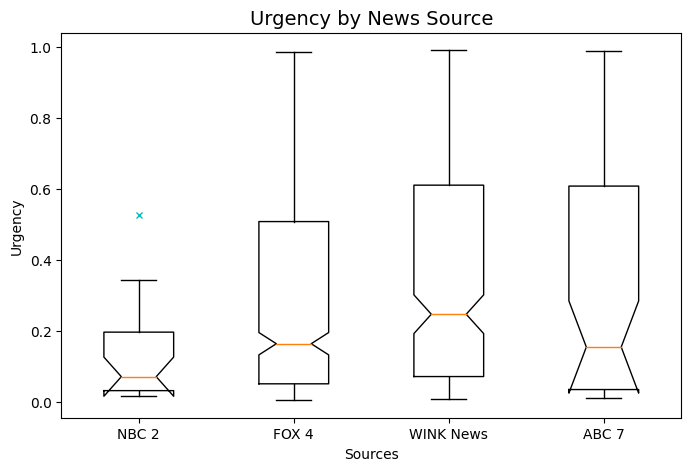

In [41]:
fig, ax = plt.subplots(figsize=(8, 5))

sources=set(df['Source'])
business_stars=[]
for star_value in sources:
    business_stars.append(df.loc[df['Source'] == star_value]['Urgency'])

pos = np.arange(len(business_stars)) + 1
bp = ax.boxplot(business_stars, sym='cx', positions=pos, notch=1)

plt.setp(bp['fliers'], markersize=5.0)
ax.set_xticklabels(sources)
ax.set_xlabel('Sources')
ax.set_ylabel('Urgency')

ax.set_title('Urgency by News Source', fontsize=14)

<Axes: xlabel='Source'>

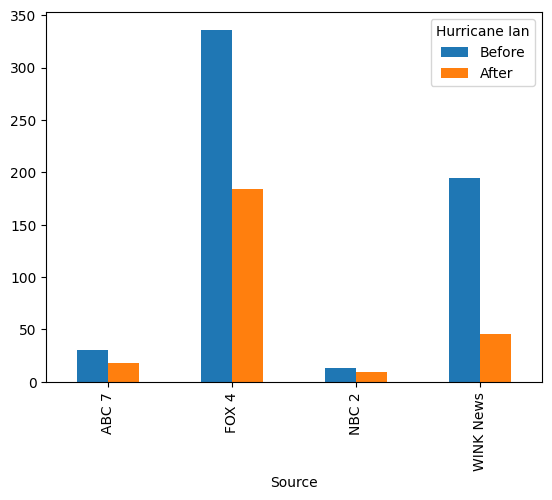

In [42]:
pd.crosstab([df['Source']],df['Hurricane Ian'],margins=False)[['Before','After']].plot(kind = 'bar',legend = True,stacked = False)

In [43]:
pd.crosstab([df['Source']],df['Hurricane Ian'],margins=False)[['Before','After']]

Hurricane Ian,Before,After
Source,,
ABC 7,30,18
FOX 4,336,184
NBC 2,13,9
WINK News,195,46


In [44]:
#find percent drop in number of climate change articles by news source
temptab=pd.crosstab([df['Source']],df['Hurricane Ian'],margins=False)[['Before','After']]
percentdrop=[]
for index, row in temptab.iterrows():
    percentdrop.append(1-(row['After']/row['Before']))
temptab['Percent Drop']=percentdrop
temptab

Hurricane Ian,Before,After,Percent Drop
Source,,,
ABC 7,30,18,0.400000
FOX 4,336,184,0.452381
NBC 2,13,9,0.307692
WINK News,195,46,0.764103


In [45]:
#average urgency before vs after Hurricane Ian
df.groupby('Hurricane Ian')['Urgency'].mean().sort_index().reindex(["Before", "After"])

Hurricane Ian
Before    0.297018
After     0.342605
Name: Urgency, dtype: float64

In [46]:
df.reset_index(inplace=True)

In [47]:
#add alternative date format
dates2=[]
for i in df['Date']:
    dates2.append(int(i[2:4]+i[-2:]))
df['YearMonth']=dates2

In [48]:
#add another alternative date format
dates3=[0]
k=0
for i in range(1,len(df)):
    if df['Date'][i]!=df['Date'][i-1]:
        k+=1
    dates3.append(k)
df['SequentialMonths']=dates3

In [49]:
#ordinal date format for graphs
df['Ordinal']=df['Dates'].map(datetime.datetime.toordinal)

In [50]:
#make a before and after dataframe
beforedf=df.loc[df['Hurricane Ian']=="Before"]
afterdf=df.loc[df['Hurricane Ian']=="After"]

In [51]:
#make labels for graphs
theseries=df.groupby('Date')['Urgency'].mean().sort_index()
monthlabels=list(theseries.index)
theseries=beforedf.groupby('Date')['Urgency'].mean().sort_index()
beforemonthlabels=list(theseries.index)
theseries=afterdf.groupby('Date')['Urgency'].mean().sort_index()
aftermonthlabels=list(theseries.index)

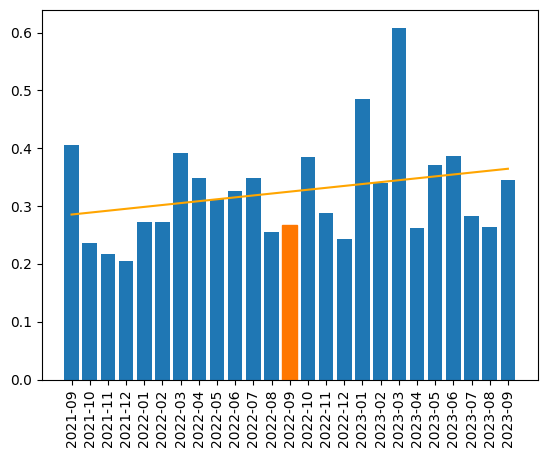

In [52]:
#urgency by month with linear regression line based on average
theseries=df.groupby('SequentialMonths')['Urgency'].mean().sort_index()
yearmonth=np.array(list(theseries.index))
urgencyp=theseries.values
lm = LinearRegression()
lm.fit(yearmonth.reshape(-1, 1),urgencyp)
barlist=plt.bar(yearmonth, urgencyp)
barlist[12].set_color('#FF7700')
plt.xticks(np.arange(len(monthlabels)), monthlabels,rotation=90)
plt.plot(yearmonth, lm.coef_*yearmonth+lm.intercept_, color='orange')

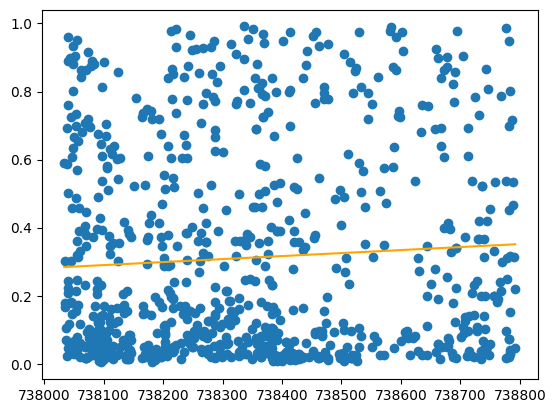

In [53]:
#urgency in chronological order with linear regression line - overall
yearmonth=np.array(list(df['Ordinal']))
urgencyp=df['Urgency']
lm = LinearRegression()
lm.fit(yearmonth.reshape(-1, 1),urgencyp)
plt.scatter(yearmonth, urgencyp)
plt.plot(yearmonth, lm.coef_*yearmonth+lm.intercept_, color='orange')
overallslopelm=lm.coef_
overallintercept=lm.intercept_

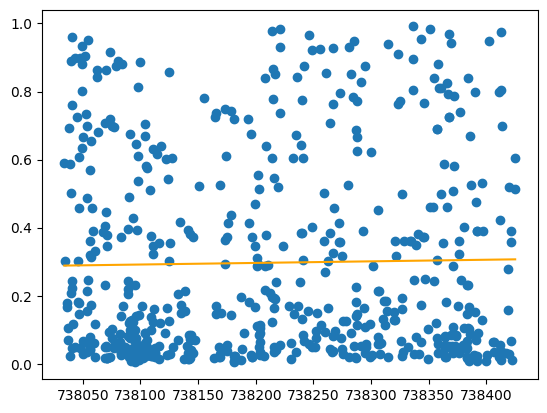

In [54]:
#urgency in chronological order with linear regression line - before only
yearmonth=np.array(list(beforedf['Ordinal']))
urgencyp=beforedf['Urgency']
lm = LinearRegression()
lm.fit(yearmonth.reshape(-1, 1),urgencyp)
plt.scatter(yearmonth, urgencyp)
plt.plot(yearmonth, lm.coef_*yearmonth+lm.intercept_, color='orange')
beforeslopelm=lm.coef_

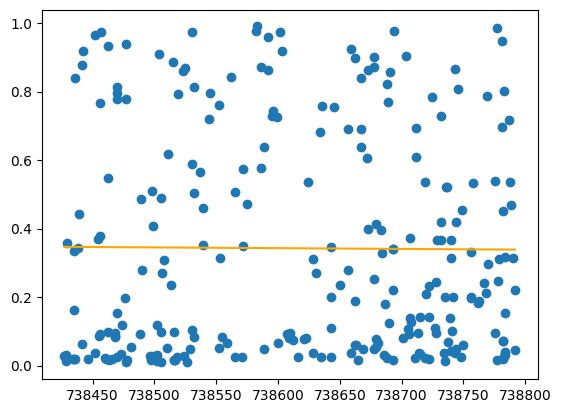

In [55]:
#urgency in chronological order with linear regression line - after only
yearmonth=np.array(list(afterdf['Ordinal']))
urgencyp=afterdf['Urgency']
lm = LinearRegression()
lm.fit(yearmonth.reshape(-1, 1),urgencyp)
plt.scatter(yearmonth, urgencyp)
plt.plot(yearmonth, lm.coef_*yearmonth+lm.intercept_, color='orange')
afterslopelm=lm.coef_

In [56]:
print("Before:",beforeslopelm)
print("After:",afterslopelm)
print()
print("Overall:",overallslopelm)

Before: [4.68488213e-05]
After: [-2.21476004e-05]

Overall: [8.83620321e-05]


Text(0.5, 1.0, 'Climate Change Urgency in Articles')

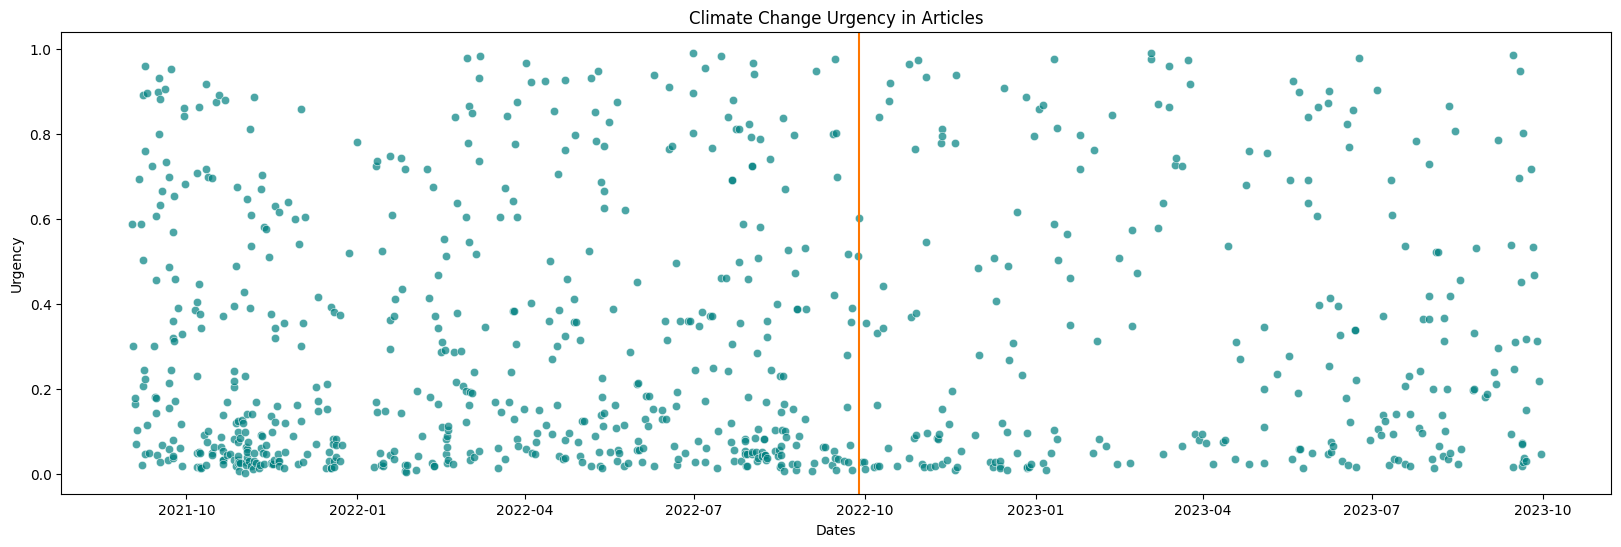

In [57]:
plt.figure(figsize=(20,6))
plt.axvline(datetime.datetime(2022, 9, 28),color="#FF7700")
sns.scatterplot(data=df, x="Dates", y='Urgency',alpha=.7,color="teal").set_title('Climate Change Urgency in Articles')

In [58]:
#number of times Hurricane Ian is mentioned by name
k=0
for i in df['Texts']:
    if "Hurricane Ian" in i:
        k+=1
print(k)

29


In [59]:
#find amount above and below the linear regression line
linerelation=[]
for i in range(0,len(df)):
    y=overallslopelm*df['Ordinal'][i]+overallintercept
    if df['Urgency'][i]>=y:
        linerelation.append('Above the Line')
    else:
        linerelation.append('Below the Line')

In [60]:
df['Linear Regression']=linerelation

<Axes: xlabel='Date'>

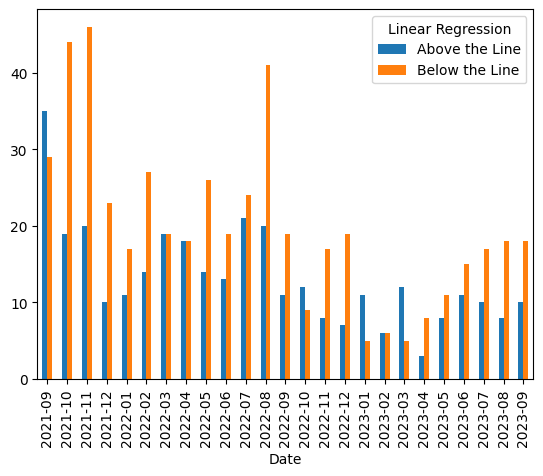

In [61]:
pd.crosstab([df['Date']],df['Linear Regression'],margins=False).plot(kind = 'bar',legend = True,stacked = False)

<Axes: xlabel='Date'>

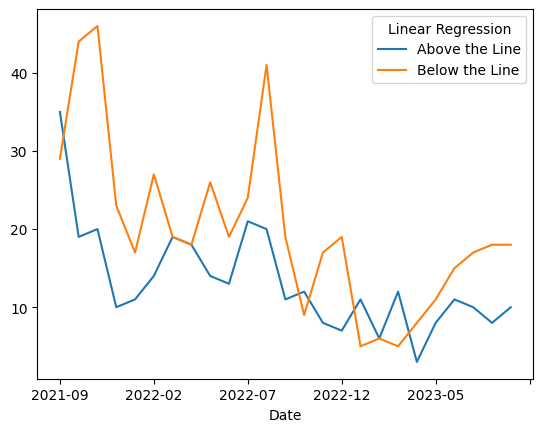

In [62]:
pd.crosstab([df['Date']],df['Linear Regression'],margins=False).plot(kind = 'line',legend = True)

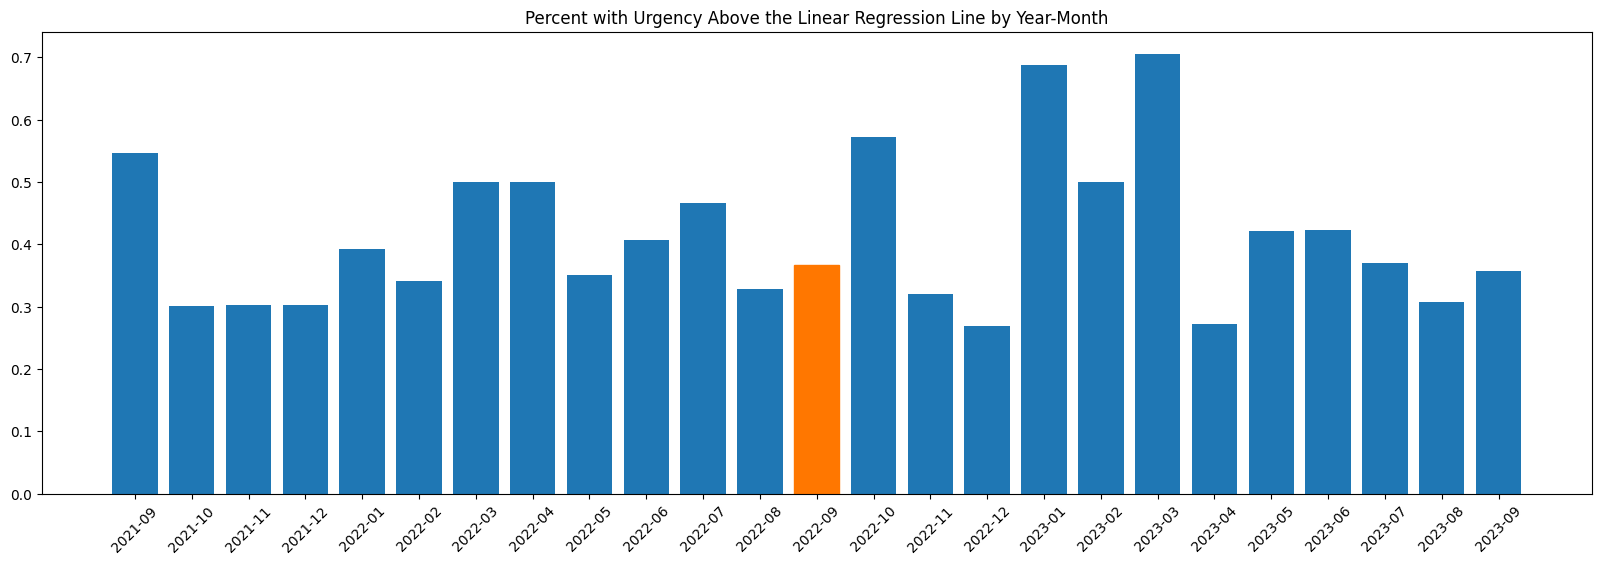

In [63]:
theseries=pd.crosstab([df['Date']],df['Linear Regression'],margins=False,normalize='index')['Above the Line']
plt.figure(figsize=(20,6))
barlist=plt.bar(theseries.index, theseries.values)
barlist[12].set_color('#FF7700')
plt.xticks(rotation=45)
plt.title("Percent with Urgency Above the Linear Regression Line by Year-Month")
plt.show()

In [64]:
#format date in six month increments
sixmonths=[]
for date in df['Dates']:
    if date<datetime.datetime.fromisoformat('2022-03-01T00:00:00'):
        sixmonths.append("-6 to 12 Months")
    elif date<datetime.datetime.fromisoformat('2022-09-01T00:00:00'):
        sixmonths.append("-0 to 6 Months")
    elif date<datetime.datetime.fromisoformat('2022-10-01T00:00:00'):
        sixmonths.append("0 Months")
    elif date<datetime.datetime.fromisoformat('2023-04-01T00:00:00'):
        sixmonths.append("0 to 6 Months")
    else:
        sixmonths.append("6 to 12 Months")
df['Six-Month Spans']=sixmonths

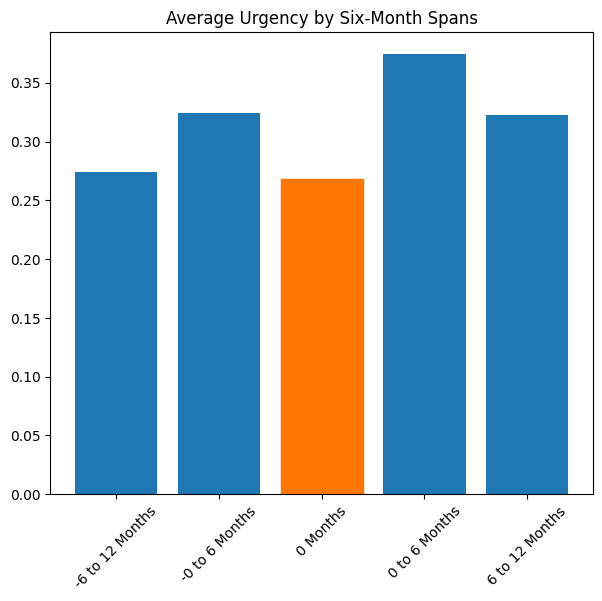

In [65]:
theseries=df.groupby('Six-Month Spans')['Urgency'].mean().reindex(["-6 to 12 Months","-0 to 6 Months","0 Months","0 to 6 Months","6 to 12 Months"])
plt.figure(figsize=(7,6))
barlist=plt.bar(theseries.index, theseries.values)
barlist[2].set_color('#FF7700')
plt.xticks(rotation=45)
plt.title("Average Urgency by Six-Month Spans")
plt.show()

In [66]:
#exact values
df.groupby('Six-Month Spans').agg({'Urgency':'mean'}).reindex(["-6 to 12 Months","-0 to 6 Months","0 Months","0 to 6 Months","6 to 12 Months"])

,Urgency
Six-Month Spans,
-6 to 12 Months,0.273913
-0 to 6 Months,0.324280
0 Months,0.267911
0 to 6 Months,0.374359
6 to 12 Months,0.322463


In [67]:
df.to_excel("ClimateArticles7Sentiment.xlsx",index=False)